In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import ndimage
import seaborn as sns

/home/barto/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
import rasterio
import rasterio.plot as rioplot
from rasterio import crs
from rasterio.features import shapes

In [3]:
!ls ./SnowGIS_SHP

Cholera_Deaths.dbf   OSMap_Grayscale.tif.aux.xml  Pumps.shx
Cholera_Deaths.prj   OSMap_Grayscale.tif.ovr	  README.txt
Cholera_Deaths.sbn   OSMap.tfw			  SnowMap.tfw
Cholera_Deaths.sbx   OSMap.tif			  SnowMap.tif
Cholera_Deaths.shp   Pumps.dbf			  SnowMap.tif.aux.xml
Cholera_Deaths.shx   Pumps.prj			  SnowMap.tif.ovr
OSMap_Grayscale.tfw  Pumps.sbx
OSMap_Grayscale.tif  Pumps.shp


In [4]:
!ls /home/barto/METH/

John Snow Cholera.ipynb  SnowGIS_SHP


Converting the rasterized map to a GeoDataFrame

In [5]:
with rasterio.drivers():
    with rasterio.open('SnowGIS_SHP/OSMap_Grayscale.tif') as src:
        image = src.read(1) # first band
        tif_crs = src.meta['crs']
        # creating a python generator for shapes present in the tif image
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for (s, v) 
        in shapes(image, connectivity=8, transform=src.affine))

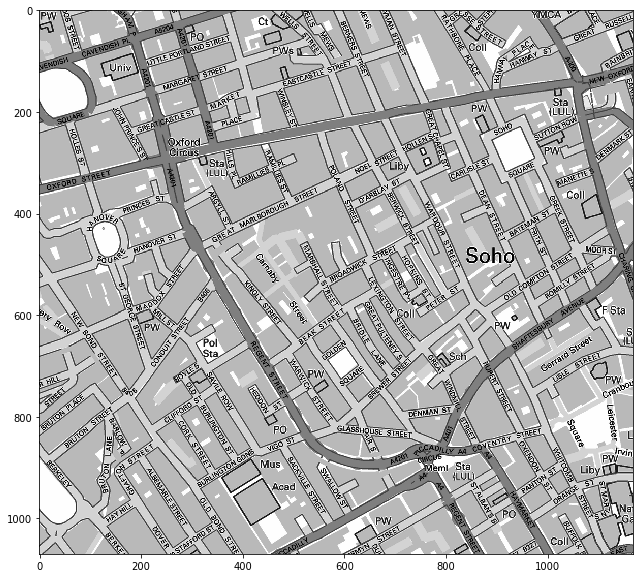

In [6]:
rcParams['figure.figsize'] = 18,10
rioplot.show(image, cmap='gray')

In [7]:
# converting the shapes in GeoDataFrame
geoms = list(results)
gpd_osmap  = gpd.GeoDataFrame.from_features(geoms, crs=tif_crs)

In [8]:
gpd_osmap.crs

CRS({'proj': 'tmerc', 'lat_0': 49, 'lon_0': -2, 'k': 0.9996012717, 'x_0': 400000, 'y_0': -100000, 'datum': 'OSGB36', 'units': 'm', 'no_defs': True})

In [9]:
gpd_osmap.head()

,geometry,raster_val
0,"POLYGON ((528800 181518.9999999999, 528800 181...",105.0
1,"POLYGON ((528802 181518.9999999999, 528802 181...",102.0
2,"POLYGON ((528803 181518.9999999999, 528803 181...",95.0
3,"POLYGON ((528804 181518.9999999999, 528804 181...",101.0
4,"POLYGON ((528805 181518.9999999999, 528805 181...",81.0


In [10]:
deaths_shp =  gpd.read_file('./SnowGIS_SHP/Cholera_Deaths.shp')
deaths_shp.head()

,Id,Count,geometry
0,0,3,POINT (529308.7414200425 181031.3515464273)
1,0,2,POINT (529312.163571333 181025.1724011325)
2,0,1,POINT (529314.3824294576 181020.2936884186)
3,0,1,POINT (529317.3796448297 181014.2587706869)
4,0,4,POINT (529320.6754489439 181007.8716281414)


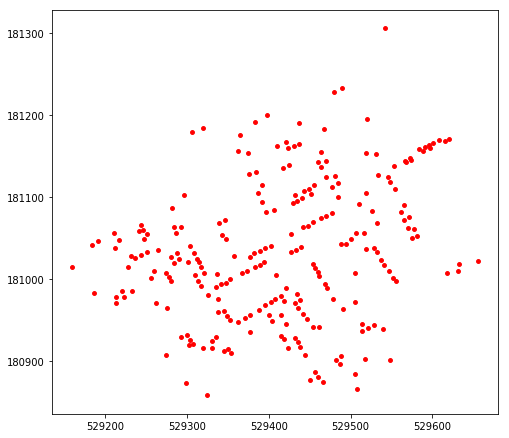

In [11]:
rcParams['figure.figsize'] = 8,8
deaths_shp.plot(markersize=15, color="red");

In [12]:
pumps_shp =  gpd.read_file('./SnowGIS_SHP/Pumps.shp')

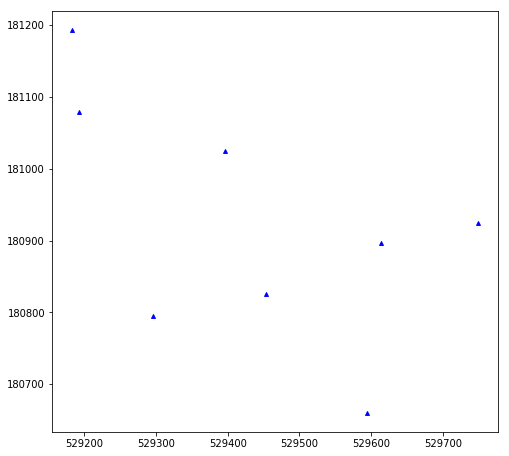

In [13]:
pumps_shp.plot(markersize=15, marker='^', color="blue");

In [14]:
# Reproject geometries using the crs of of the map
deaths_shp['geometry'] = deaths_shp['geometry'].to_crs(crs=gpd_osmap.crs)
pumps_shp['geometry'] = pumps_shp['geometry'].to_crs(crs=gpd_osmap.crs)

# Not necessary in this case as the data are already mapped but I leave there as a reminder

# Visualization

<div class="alert alert-success">
    <b>Visualization of the data</b>
    <ul>
        <li>blue triangles: pumps</li>
        <li>red circles: location of deaths, the bigger the higher is the number of death</li>
    </ul> 
</div>

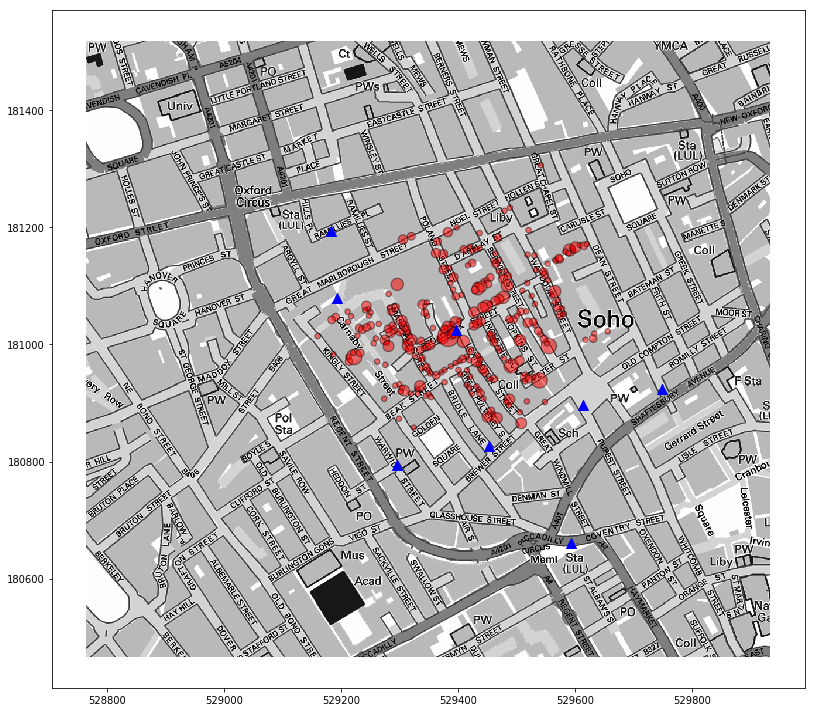

In [15]:
rcParams['figure.figsize'] = 18,10

# setting the map as background
my_map = gpd_osmap.plot(column="raster_val", cmap='gray')

# Add depths on top of the previous map
deaths_shp.plot(ax=my_map, color="red", markersize=deaths_shp['Count']*30, edgecolor="black", alpha=0.5)

# Add pumps on top of the previous map
pumps_shp.plot(ax=my_map, color="blue", markersize=100, marker='^')

# Remove the empty white-space around the axes
plt.tight_layout()

<div class="alert alert-info">
    <b>Visualization of density map.</b> Provided that we don't know about the pumps, this would help to extract spatial cues related to the deaths.
</div>

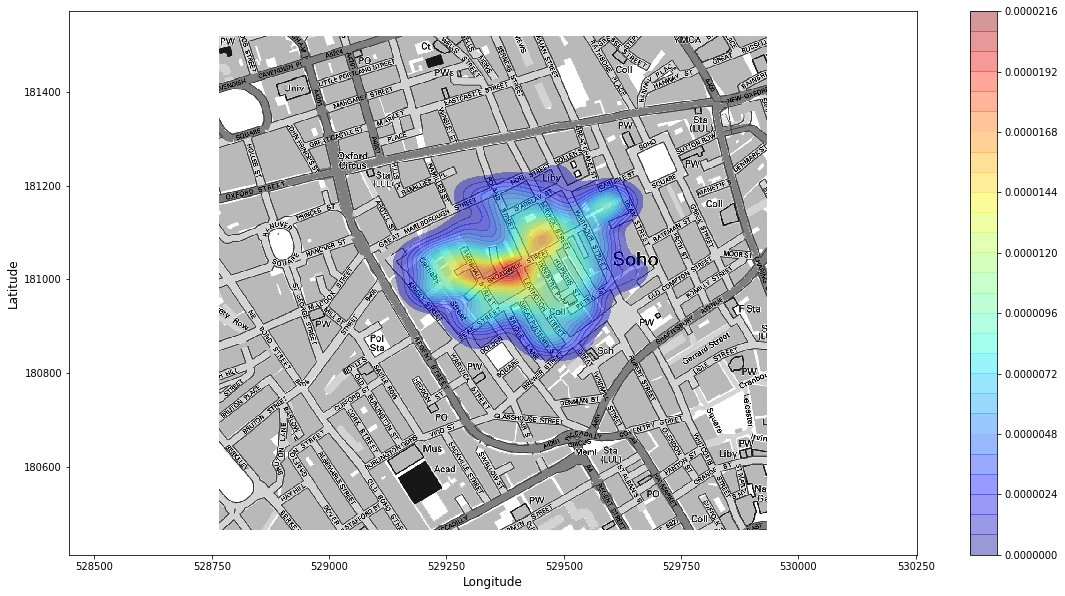

In [34]:
f, ax = plt.subplots(1, figsize=(19, 10))

gpd_osmap.plot(ax=ax, column="raster_val", cmap='gray')

x_list = []
y_list = []
for i in range(len(deaths_shp)):
    pt = deaths_shp['geometry'][i]
    x_list += [pt.x] * deaths_shp['Count'][i]
    y_list += [pt.y] * deaths_shp['Count'][i]


sns.kdeplot(x_list, y_list, cmap="jet", shade=True, shade_lowest=False, n_levels=30, ax=ax, alpha=0.4, cbar=True) 
#sns.rugplot(x_list, cmap='jet', ax=ax) 
#sns.rugplot(y_list, color='r', vertical=True, ax=ax);

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

#ax.set_axis_off()
plt.axis('equal')
plt.show()

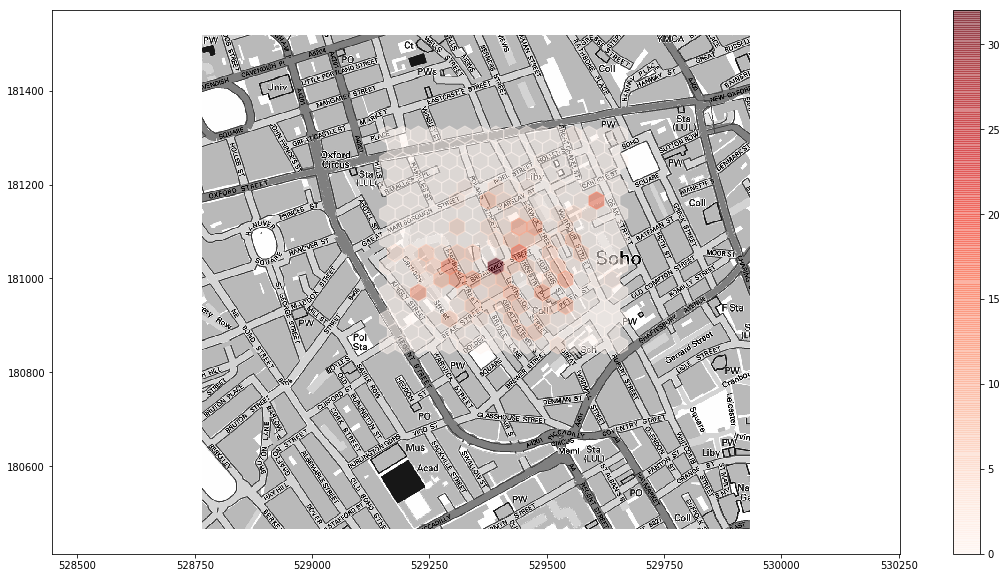

In [31]:
f, ax = plt.subplots(1, figsize=(19, 10))

gpd_osmap.plot(ax=ax, column="raster_val", cmap='gray')

x_list = []
y_list = []
for i in range(len(deaths_shp)):
    pt = deaths_shp['geometry'][i]
    x_list += [pt.x] * deaths_shp['Count'][i]
    y_list += [pt.y] * deaths_shp['Count'][i]


# Displays count of points in each polygon as an hexagon grid
hb = ax.hexbin(x_list, y_list, gridsize=15, alpha=0.5, cmap='Reds')

# Add a colorbar (optional)
plt.colorbar(hb)
plt.axis('equal')
plt.show()